# Compare Multi-tempCNN Out-of-site and Modis-tempCNN Maps

In [1]:
import os
import gdal
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

import initialise
import common
from display_utils import display_frames

## Locations of TIFFs

In [2]:
tif_dir = os.path.join(common.MAPS_DIR, 'LFMC_maps')
multi_tif = os.path.join(tif_dir, 'Multi-tempCNN_Out-of-Site_base_2017-10-01.tif')
modis_tif = os.path.join(tif_dir, 'Modis-tempCNN_2017_merge10_2017-10-01.tif')
diff_tif = os.path.join(tif_dir, 'Multi-tempCNN vs Modis-tempCNN.tif')
aux_tif = os.path.join(common.GEE_MAPS_DIR, 'GEE_EPSG-4326_2000', 'conus_aux.tif')

In [3]:
def num_pixels(start_loc, end_loc, pixel_size, convert=np.round):
    return_type = type(start_loc)
    pixels = (np.array(end_loc) - np.array(start_loc)) / np.array(pixel_size)
    if convert:
        pixels = convert(pixels)
    return return_type(pixels)

## Load the auxiliary data

In [4]:
aux_file = gdal.Open(aux_tif, gdal.GA_ReadOnly)
aux_data = aux_file.ReadAsArray()
aux_data.shape
aux_bands = [aux_file.GetRasterBand(b).GetDescription() for b in range(1, aux_file.RasterCount+1)]

## Load the Multi-tempCNN LFMC estimates

In [5]:
tif = gdal.Open(multi_tif, gdal.GA_ReadOnly)
image = tif.ReadAsArray()
shape = image.shape
shape

(2, 1383, 3217)

## Merge the auxiliary data and Multi-tempCNN estimates
The auxiliary data first needs to be aligned with the Multi-tempCNN estimates data

In [6]:
aux_transform = aux_file.GetGeoTransform()
tif_transform = tif.GetGeoTransform()
aux_offset = num_pixels((aux_transform[3], aux_transform[0]),
                        (tif_transform[3], tif_transform[0]),
                        (aux_transform[5], aux_transform[1]))
aux_offset = np.int32(aux_offset)
aux_offset

aux_data = aux_data[:, aux_offset[0]:(shape[1]+aux_offset[0]), aux_offset[1]:(shape[2]+aux_offset[1])].reshape(len(aux_bands), shape[1], shape[2])
all_data = np.concatenate((image, aux_data), axis=0)

## Convert the image to a dataframe
Extract the required fields from the numpy array and flatten to a data frame. Remove the NODATA pixels.

In [7]:
data_df = []
for col in range(all_data.shape[0]):
    temp_df = pd.DataFrame(all_data[col]).stack()
    data_df.append(temp_df)
data_df = pd.concat(data_df, axis=1, keys=['lfmc', 'conf'] + aux_bands)
data_df = data_df[data_df.lfmc.gt(-990)]
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_df.describe())

,lfmc,conf,elevation,slope,aspect,longitude,latitude,climate_zone
count,2498785.00,2498785.00,2498785.00,2498785.00,2498785.00,2498785.00,2498785.00,2498785.00
mean,111.01,9.30,798.79,6.08,160.16,-99.25,39.38,15.55
std,20.87,3.19,728.66,5.64,27.70,13.50,5.30,8.20
min,39.63,2.30,-83.57,0.00,0.00,-124.70,24.57,1.00
25%,96.85,7.28,234.72,2.58,144.43,-110.50,35.24,7.00
50%,107.52,8.74,500.90,3.69,158.20,-99.63,39.61,14.00
75%,127.62,10.54,1298.54,7.12,173.59,-89.23,43.70,25.00
max,233.05,89.84,4093.82,45.28,311.24,-66.99,49.38,29.00


# LFMC Estimation Analysis

In [8]:
df1 = data_df[(data_df.longitude < -105)
                    & ~(data_df.longitude.lt(-120) & data_df.latitude.gt(42))
                    & ~(data_df.longitude.between(-117, -110) & data_df.latitude.gt(44))
                   ][['lfmc', 'conf']].describe()
df2 = data_df[(data_df.longitude.lt(-120) & data_df.latitude.gt(42))
                    | (data_df.longitude.between(-117, -110) & data_df.latitude.gt(44))
                   ][['lfmc', 'conf']].describe()
df3 = data_df[data_df.longitude > -105][['lfmc', 'conf']].describe()
df4 = data_df[(data_df.longitude > -105)
                    & ~(data_df.longitude.between(-100, -80) & data_df.climate_zone.eq(25))
                   ][['lfmc', 'conf']].describe()
df5 = data_df[data_df.longitude.between(-100, -80) & data_df.climate_zone.eq(25)][['lfmc', 'conf']].describe()
df6 = data_df[(data_df.climate_zone == 14) & (data_df.longitude > -100)][['lfmc', 'conf']].describe()
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(
        pd.concat([df1, df2, df3, df4, df5, df6],
                  keys = ['Western CONUS excluding Pacific NW and Nth Rockies',
                          'Pacific Northwest and the northern Rockies',
                          'Mid and eastern CONUS',
                          'Mid and eastern CONUS, excluding mid-western Corn Belt',
                          'Mid-western Corn Belt',
                          'South eastern Cfa climate zone'], axis=1))

Western CONUS excluding Pacific NW and Nth Rockies            \
                                                    lfmc      conf   
count                                          732225.00 732225.00   
mean                                               93.04      8.71   
std                                                14.43      3.95   
min                                                39.63      2.30   
25%                                                87.32      6.41   
50%                                                93.60      7.72   
75%                                               100.51      9.73   
max                                               233.05     89.84   

      Pacific Northwest and the northern Rockies            \
                                            lfmc      conf   
count                                  191154.00 191154.00   
mean                                      115.90      9.94   
std                                        23.46      3.42   
min                                        70.25      3.07   
25%                                        96.08      7.50   
50%                                       112.58      9.10   
75%                                       132.69     11.62   
max                                       208.68     49.51   

      Mid and eastern CONUS             \
                       lfmc       conf   
count            1575406.00 1575406.00   
mean                 118.77       9.50   
std                   17.72       2.69   
min                   50.50       2.80   
25%                  104.69       7.73   
50%                  116.37       9.07   
75%                  132.48      10.68   
max                  218.97      58.02   

      Mid and eastern CONUS, excluding mid-western Corn Belt             \
                                                        lfmc       conf   
count                                         1177222.00     1177222.00   
mean                                              124.18           9.25   
std                                                16.89           2.83   
min                                                50.50           2.80   
25%                                               110.83           7.45   
50%                                               126.53           8.73   
75%                                               135.58          10.30   
max                                               218.97          58.02   

      Mid-western Corn Belt           South eastern Cfa climate zone            
                       lfmc      conf                           lfmc      conf  
count             398184.00 398184.00                      535812.00 535812.00  
mean                 102.88     10.24                         131.81      8.80  
std                    7.75      2.06                          13.33      2.69  
min                   70.37      4.32                          82.49      3.47  
25%                   99.01      8.74                         125.60      7.08  
50%                  103.45     10.01                         134.14      8.18  
75%                  107.37     11.51                         140.74      9.78  
max                  149.69     38.77                         180.81     41.94

# Estimation Uncertainty Analysis

## Uncertainty summary statistics

In [9]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(data_df['conf'].describe())

count   2498785.00
mean          9.30
std           3.19
min           2.30
25%           7.28
50%           8.74
75%          10.54
max          89.84
Name: conf, dtype: float64

## Percentage of pixels with uncertainty < 10

In [10]:
((data_df.conf < 10).sum() * 100 / data_df.conf.count()).round(2)

68.78

# Comparison with Modis-tempCNN

In [11]:
tif = gdal.Open(diff_tif, gdal.GA_ReadOnly)
image = tif.ReadAsArray()
all_data = np.concatenate(([image], aux_data), axis=0)
diff_df = []
for col in range(all_data.shape[0]):
    temp_df = pd.DataFrame(all_data[col]).stack()
    diff_df.append(temp_df)
diff_df = pd.concat(diff_df, axis=1, keys=['diff'] + aux_bands)
diff_df = diff_df[diff_df['diff'].gt(-990)]

## Summary statistics

In [12]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(diff_df['diff'].describe())

count   2498785.00
mean          3.33
std          14.06
min         -75.88
25%          -5.27
50%           4.19
75%          10.96
max         111.30
Name: diff, dtype: float64

## Percentage of pixels where Multi-tempCNN estimate is higher than Modis-tempCNN

In [13]:
print('Percentage with Multi-tempCNN estimate > Modis-tempCNN:',
      ((diff_df['diff'] >= 0).sum() * 100 / diff_df['diff'].count()).round(2))

print('Percentage with rounded Multi-tempCNN estimate > Modis-tempCNN:',
      ((diff_df['diff'].round() >= 0).sum() * 100 / diff_df['diff'].count()).round(2))

print('Percentage with Multi-tempCNN estimate close to or greater than Modis-tempCNN:',
      ((diff_df['diff'] >= -1.3).sum() * 100 / diff_df['diff'].count()).round(2))

print('Percentage with absolute difference between Multi-tempCNN estimate and Modis-tempCNN < 4:',
      ((diff_df['diff'].abs() < 4).sum() * 100 / diff_df['diff'].count()).round(2))

print('Percentage with Multi-tempCNN estimate greater than 4 more than Modis-tempCNN:',
      ((diff_df['diff'] > 4).sum() * 100 / diff_df['diff'].count()).round(2))

Percentage with Multi-tempCNN estimate > Modis-tempCNN: 63.31
Percentage with rounded Multi-tempCNN estimate > Modis-tempCNN: 64.64
Percentage with Multi-tempCNN estimate close to or greater than Modis-tempCNN: 66.66
Percentage with absolute difference between Multi-tempCNN estimate and Modis-tempCNN < 4: 21.89
Percentage with Multi-tempCNN estimate greater than 4 more than Modis-tempCNN: 50.69


## Estimation differences in Regions of Interest

In [34]:
tif = gdal.Open(modis_tif, gdal.GA_ReadOnly)
image = tif.ReadAsArray()
all_data = np.concatenate((image, aux_data), axis=0)
modis_df = []
for col in range(all_data.shape[0]):
    temp_df = pd.DataFrame(all_data[col]).stack()
    modis_df.append(temp_df)
modis_df = pd.concat(modis_df, axis=1, keys=['lfmc', 'conf'] + aux_bands)
modis_df = modis_df[modis_df['lfmc'].gt(-990)]
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(modis_df['lfmc'].describe())

count   2500759.00
mean        107.68
std          19.40
min          46.23
25%          92.97
50%         109.12
75%         122.37
max         226.95
Name: lfmc, dtype: float64

In [27]:
temp_df3 = pd.concat([
    diff_df[diff_df.longitude.lt(-120) & diff_df.latitude.gt(42) & diff_df.climate_zone.isin([9, 15])][['diff']].mean(),
    diff_df[diff_df.latitude.lt(30) & diff_df.climate_zone.eq(6) ][['diff']].mean(),
    diff_df[diff_df.latitude.lt(30) & diff_df.climate_zone.isin([1, 2, 3])][['diff']].mean(),
    diff_df[diff_df.longitude.between(-100, -80) & diff_df.climate_zone.eq(25)][['diff']].mean(),
    diff_df[diff_df.climate_zone.eq(4)][['diff']].mean()],
    keys = ['Pacific Northwest', 'Southern Texas', 'Southern Florida', 'Mid-west Cornbelt', 'Deserts'], axis=1)
# with pd.option_context('display.float_format', '{:.2f}'.format):
#     display(temp_df3

In [28]:
temp_df1 = pd.concat([
    data_df[data_df.longitude.lt(-120) & data_df.latitude.gt(42) & data_df.climate_zone.isin([9, 15])][['lfmc']].mean(),
    data_df[data_df.latitude.lt(30) & data_df.climate_zone.eq(6) ][['lfmc']].mean(),
    data_df[data_df.latitude.lt(30) & data_df.climate_zone.isin([1, 2, 3])][['lfmc']].mean(),
    data_df[data_df.longitude.between(-100, -80) & data_df.climate_zone.eq(25)][['lfmc']].mean(),
    data_df[data_df.climate_zone.eq(4)][['lfmc']].mean()],
    keys = ['Pacific Northwest', 'Southern Texas', 'Southern Florida', 'Mid-west Cornbelt', 'Deserts'], axis=1)
# with pd.option_context('display.float_format', '{:.2f}'.format):
#     display(temp_df1)

In [29]:
temp_df2 = pd.concat([
    modis_df[modis_df.longitude.lt(-120) & modis_df.latitude.gt(42) & modis_df.climate_zone.isin([9, 15])][['lfmc']].mean(),
    modis_df[modis_df.latitude.lt(30) & modis_df.climate_zone.eq(6)][['lfmc']].mean(),
    modis_df[modis_df.latitude.lt(30) & modis_df.climate_zone.isin([1, 2, 3])][['lfmc']].mean(),
    modis_df[modis_df.longitude.between(-100, -80) & modis_df.climate_zone.eq(25)][['lfmc']].mean(),
    modis_df[modis_df.climate_zone.eq(4)][['lfmc']].mean()],
    keys = ['Pacific Northwest', 'Southern Texas', 'Southern Florida', 'Mid-west Cornbelt', 'Deserts'], axis=1)
# with pd.option_context('display.float_format', '{:.2f}'.format):
#     display(temp_df2)

In [32]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(pd.concat([temp_df1, temp_df2, temp_df3], keys=['Multi-tempCNN', 'Modis-tempCNN', 'Difference']).droplevel(1))

,Pacific Northwest,Southern Texas,Southern Florida,Mid-west Cornbelt,Deserts
Multi-tempCNN,138.89,158.73,165.13,102.88,62.91
Modis-tempCNN,98.96,115.37,126.36,115.79,82.89
Difference,39.92,43.36,38.77,-12.92,-19.97


## Estimation differences by climate zone

In [15]:
czones = pd.read_csv(os.path.join(common.SOURCE_DIR, 'Climate_zones.csv'), index_col=0)
temp_df = data_df.groupby(['climate_zone'])[['lfmc', 'conf']].mean().merge(czones['Code'], left_index=True, right_index=True).set_index('Code')
temp_df.columns = ['Mean LFMC', 'Uncertainty']
temp_df['Differences'] = diff_df.groupby(['climate_zone'])[['diff']].mean().merge(czones['Code'], left_index=True, right_index=True).set_index('Code')
temp_df['Pixel Count'] = data_df.groupby(['climate_zone'])[['lfmc']].count().merge(czones['Code'], left_index=True, right_index=True).set_index('Code')
temp_df['% of CONUS'] = temp_df['Pixel Count'] * 100 / data_df.shape[0]
temp_df.rename_axis('Climate Zone', inplace=True)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(temp_df.sort_values('Uncertainty'))

,Mean LFMC,Uncertainty,Differences,Pixel Count,% of CONUS
Climate Zone,,,,,
Csa,74.68,7.69,7.72,36133,1.45
BSk,99.40,7.82,7.07,616658,24.68
Dsa,97.00,7.92,14.62,1245,0.05
Dsb,116.90,8.43,10.07,68926,2.76
Dfc,107.74,8.61,0.02,68657,2.75
Cfa,131.70,8.80,5.19,538052,21.53
Dfb,122.12,9.04,6.42,321091,12.85
Dwa,112.33,9.59,9.37,13299,0.53
Dsc,127.65,9.97,7.86,19668,0.79


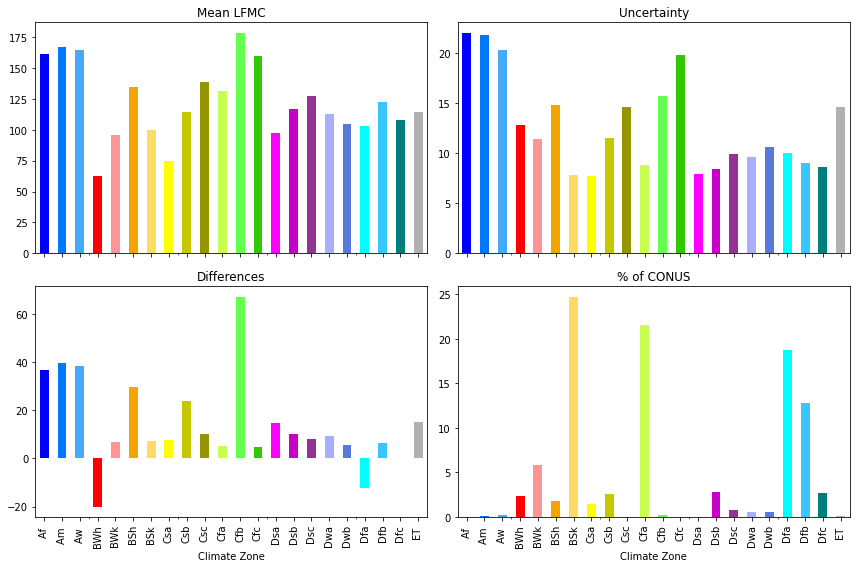

In [16]:
colours = czones[czones.Code.isin(temp_df.index)][['Red', 'Green', 'Blue']].values / 256
axes = temp_df[['Mean LFMC', 'Uncertainty', 'Differences', '% of CONUS']].plot(kind='bar', subplots=True, layout=(2,2), figsize=(12, 8), sharex=True, legend=False)
for ax in axes.flatten():
    for p, c in zip(ax.patches, colours):
        p.set_facecolor(c)
plt.tight_layout()

In [17]:
czone_file = os.path.join(common.MAPS_DIR, 'Climate_zones', 'climate_zones.vrt')
czone_tif = gdal.Open(czone_file, gdal.GA_ReadOnly)
czone_array = czone_tif.ReadAsArray()
czone_array = czone_array.astype(np.int8)
df2 = pd.DataFrame(czone_array.flatten(), columns=['czone'])
df2 = df2[df2.czone > 0]
df2.groupby(['czone']).size()

czone
1       17469
2       11609
3       29842
4      277693
5      679071
6      208349
7     2892468
8      170455
9      306165
10        431
14    2557444
15      55324
16       4555
17       6026
18     323451
19     725225
21      63453
22      70050
23      37998
25    2241811
26    1741296
27    2688819
29     988188
30       1068
dtype: int64